In [1]:
# Libraries
from pathlib import Path
import shutil
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import pretty_midi
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

## EDA and Data Cleaning

In [2]:
# Define the source and destination directories

source_root = Path(r"C:\Users\anitr\AAI511_Group6Project\su25-aai511-group6\dataset\selected_composers")

destination_root = Path(r"C:\Users\anitr\AAI511_Group6Project\su25-aai511-group6\dataset\selected_composers_renamed")   
destination_root.mkdir(parents=True, exist_ok=True)

# Iterate through each composer directory and copy files with prefix indicating the composer's name
count = 0
composer_counts = {}

for composer_dir in source_root.iterdir():
    if composer_dir.is_dir():
        composer_name = composer_dir.name
        composer_count = 0
        print(f"Processing composer: {composer_name}")
        

        for file in composer_dir.rglob("*.mid*"):
            new_file_name = f"{composer_name}_{file.name}"
            new_file_path = destination_root / new_file_name
            shutil.copy(file, new_file_path)
            composer_count += 1
            count += 1

        composer_counts[composer_name] = composer_count
        print(f"Count: {composer_name}: {composer_count}")
            
           
print("All files copied successfully.")
print(f"Total files copied: {count}")



Processing composer: Bach
Count: Bach: 1024
Processing composer: Beethoven
Count: Beethoven: 220
Processing composer: Chopin
Count: Chopin: 136
Processing composer: Mozart
Count: Mozart: 257
All files copied successfully.
Total files copied: 1637


In [3]:
# Create a csv file with composer_name as target and file_name as feature

csv_file_path = Path(r"C:\Users\anitr\AAI511_Group6Project\su25-aai511-group6\dataset") 

composer_data = []
for file in destination_root.glob("*.mid*"):
    composer_name = file.stem.split('_')[0]  
    composer_data.append({"composer_name": composer_name, "file_name": file.name})
composer_df = pd.DataFrame(composer_data)
composer_df.to_csv(csv_file_path / "composer_files.csv", index=False)
print("CSV file created successfully.")



CSV file created successfully.


In [4]:
# Create a dataframe from the composer_files.csv file
composer_df = pd.read_csv(csv_file_path / "composer_files.csv")
print("DataFrame created successfully.")
print(composer_df.head())

DataFrame created successfully.
  composer_name          file_name
0          Bach  Bach_003706b_.mid
1          Bach  Bach_003806b_.mid
2          Bach  Bach_003907bv.mid
3          Bach  Bach_003907b_.mid
4          Bach  Bach_004003b_.mid


In [5]:
# Append the number of notes and duration of each midi file to the dataframe
notes_list = []
durations_list = []

for file_name in composer_df['file_name']:
    file_path = destination_root / file_name
    try:
        midi_data = pretty_midi.PrettyMIDI(str(file_path))
        num_notes = sum(len(instrument.notes) for instrument in midi_data.instruments)
        duration_sec = round(midi_data.get_end_time(), 2)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        num_notes = None
        durations_sec = None

    notes_list.append(num_notes)
    durations_list.append(duration_sec)

print(len(notes_list), len(durations_list), len(composer_df))

composer_df['num_notes'] = notes_list
composer_df['duration_sec'] = durations_list

composer_df.to_csv(csv_file_path / "composer_files_appended.csv", index=False)
print("CSV file with appended data created successfully.")

print(composer_df.head())



C:\Users\anitr\AppData\Roaming\Python\Python310\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Error processing C:\Users\anitr\AAI511_Group6Project\su25-aai511-group6\dataset\selected_composers_renamed\Beethoven_Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Error processing C:\Users\anitr\AAI511_Group6Project\su25-aai511-group6\dataset\selected_composers_renamed\Mozart_K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
1637 1637 1637
CSV file with appended data created successfully.
  composer_name          file_name  num_notes  duration_sec
0          Bach  Bach_003706b_.mid      304.0         46.96
1          Bach  Bach_003806b_.mid      253.0         45.00
2          Bach  Bach_003907bv.mid      285.0         42.50
3          Bach  Bach_003907b_.mid      285.0         42.50
4          Bach  Bach_004003b_.mid      204.0         30.00


In [6]:
print(composer_df.shape)
print(composer_df.describe())
print(composer_df.isnull().sum())



(1637, 4)
          num_notes  duration_sec
count   1635.000000   1637.000000
mean    3157.804893    248.032266
std     4862.454120    320.059087
min       83.000000     17.500000
25%      366.000000     51.000000
50%     1202.000000    136.760000
75%     3865.000000    330.860000
max    47745.000000   5209.310000
composer_name    0
file_name        0
num_notes        2
duration_sec     0
dtype: int64


### Missing values

Only 2 missing values in num_notes colum, none in duration_sec column. Drop missing files with missing values. 

Options: 

1. Drop those two files. 


In [7]:
# Drop rows with missing values in 'num_notes'
composer_df = composer_df.dropna(subset=['num_notes'])
print("Missing values dropped. Remaining rows:", composer_df.shape[0])


Missing values dropped. Remaining rows: 1635


In [8]:
# Count rows with missing values in 'num_notes' 
missing_count = composer_df['num_notes'].isnull().sum()
print("Number of missing values in 'num_notes':", missing_count)

# Count rows with missing values in 'duration_sec'
missing_duration_count = composer_df['duration_sec'].isnull().sum()
print("Number of missing values in 'duration_sec':", missing_duration_count)

# Update the CSV file after dropping missing values
composer_df.to_csv(csv_file_path / "composer_files_cleaned.csv", index=False)
print("CSV file after dropping missing values created successfully.")



Number of missing values in 'num_notes': 0
Number of missing values in 'duration_sec': 0
CSV file after dropping missing values created successfully.


composer_name
Bach         1024
Mozart        256
Beethoven     219
Chopin        136
Name: count, dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

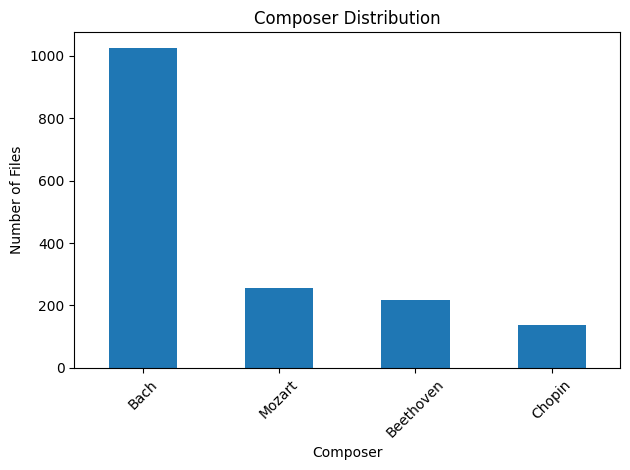

In [9]:
print(composer_df['composer_name'].value_counts())
composer_df['composer_name'].value_counts().plot(kind='bar')
plt.title('Composer Distribution')
plt.xlabel('Composer')
plt.ylabel('Number of Files')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show

### Data in dataset is imbalanced! 

Options: 
1. Downsampling - Discards alot of data
2. Upsampling - Produces duplicates and can cause overfitting
3. Use class weights - Give more weight to minority classes
4. Data augmentation for minority class - possibly add? 

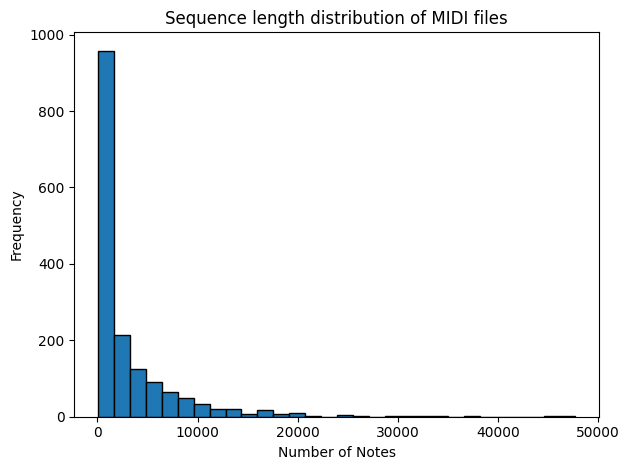

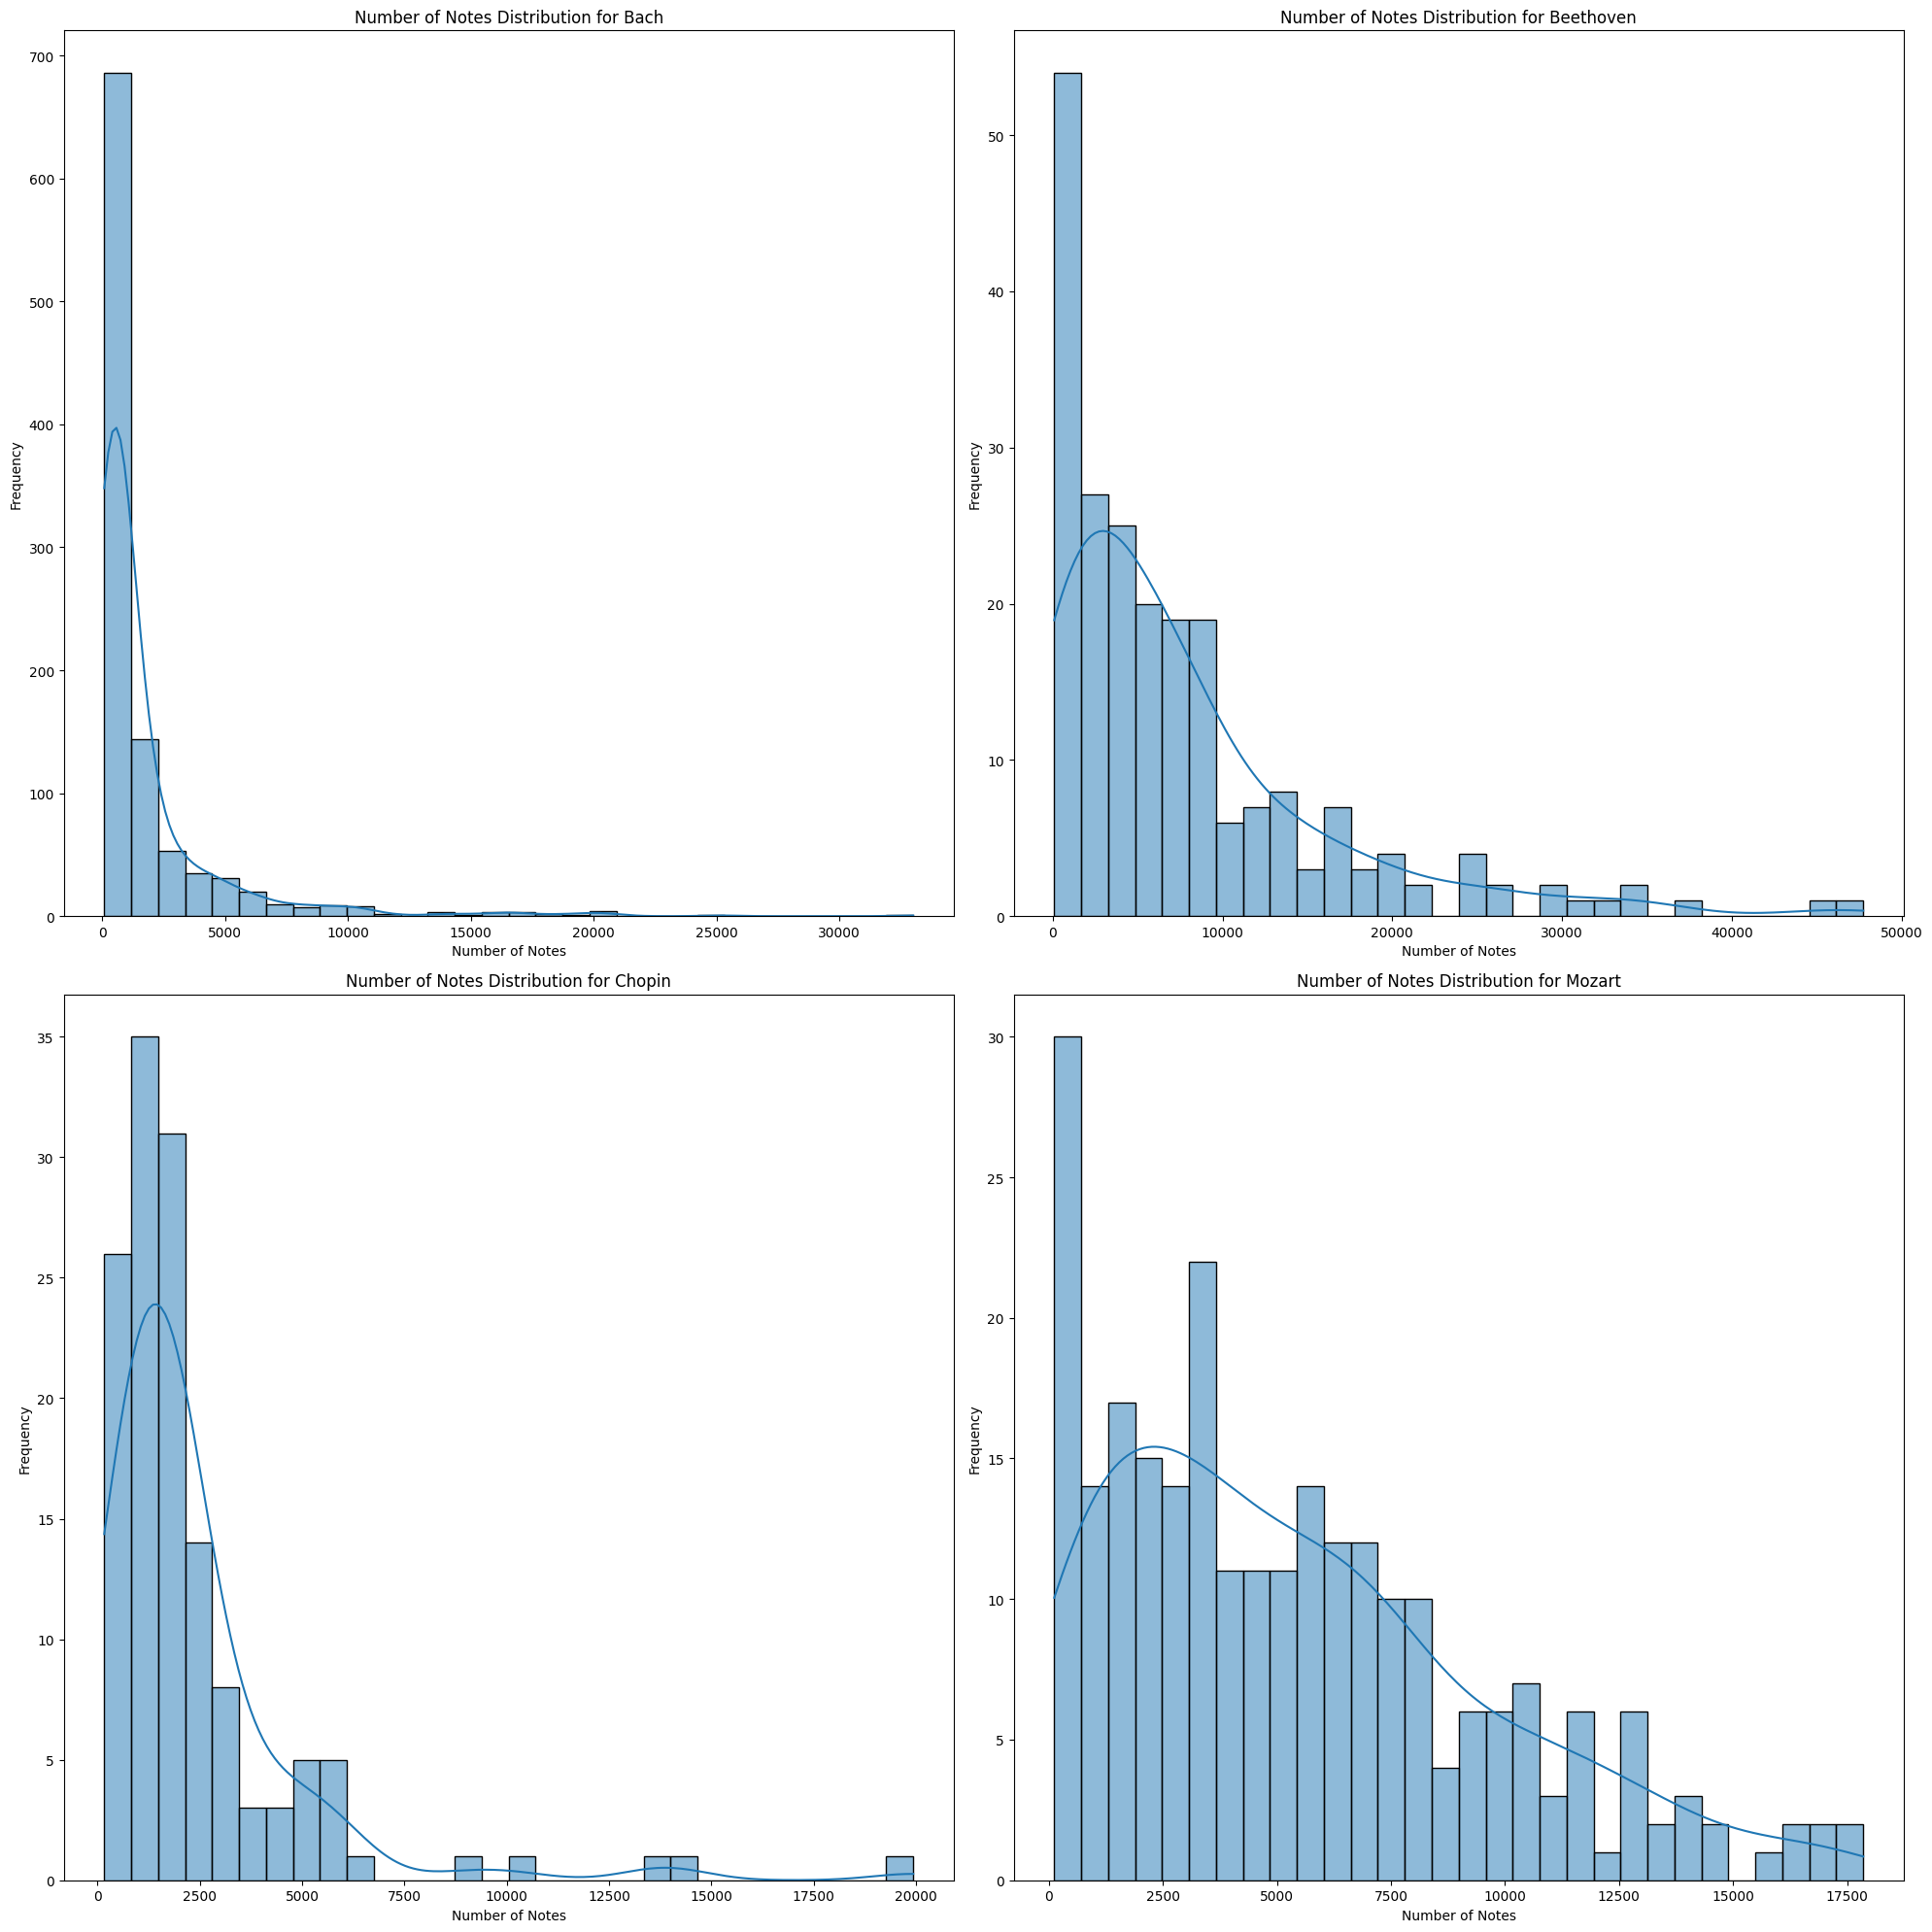

In [10]:
# Plot the distribution of the number of notes in each midi file for all composers
composer_df['num_notes'].plot(kind='hist', bins=30, edgecolor='black')
plt.title('Sequence length distribution of MIDI files')
plt.xlabel('Number of Notes')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Create a plot for each composer showing the distribution of the number of notes in their MIDI files 
plt.figure(figsize=(20, 20))
for i, composer in enumerate(composer_df['composer_name'].unique(), 1):
    composer_data = composer_df[composer_df['composer_name'] == composer]
    plt.subplot(2, 2, i)
    sns.histplot(composer_data['num_notes'], bins=30, kde=True)
    plt.title(f'Number of Notes Distribution for {composer}')
    plt.xlabel('Number of Notes')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()




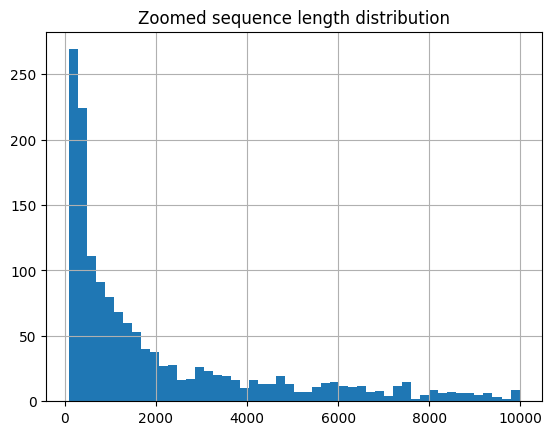

In [11]:
composer_df[composer_df['num_notes'] <= 10000]['num_notes'].hist(bins=50)
plt.title("Zoomed sequence length distribution")
plt.show()

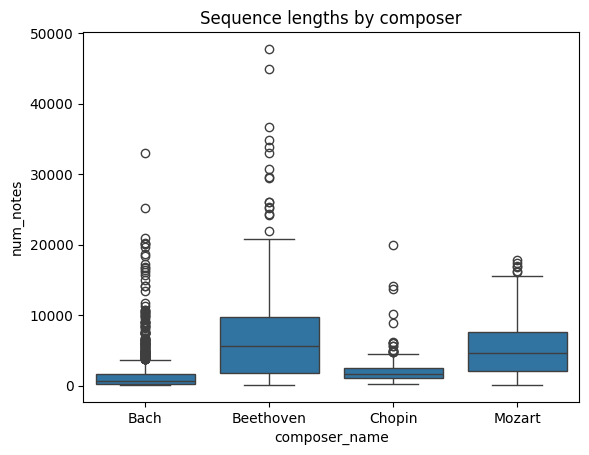

In [12]:
sns.boxplot(x='composer_name', y='num_notes', data=composer_df)
plt.title("Sequence lengths by composer")
plt.show()

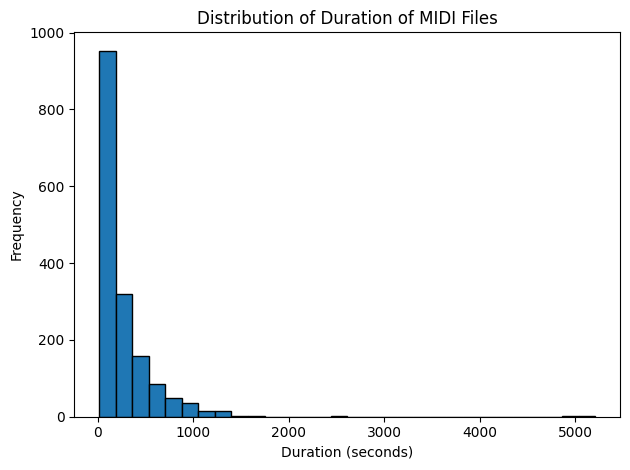

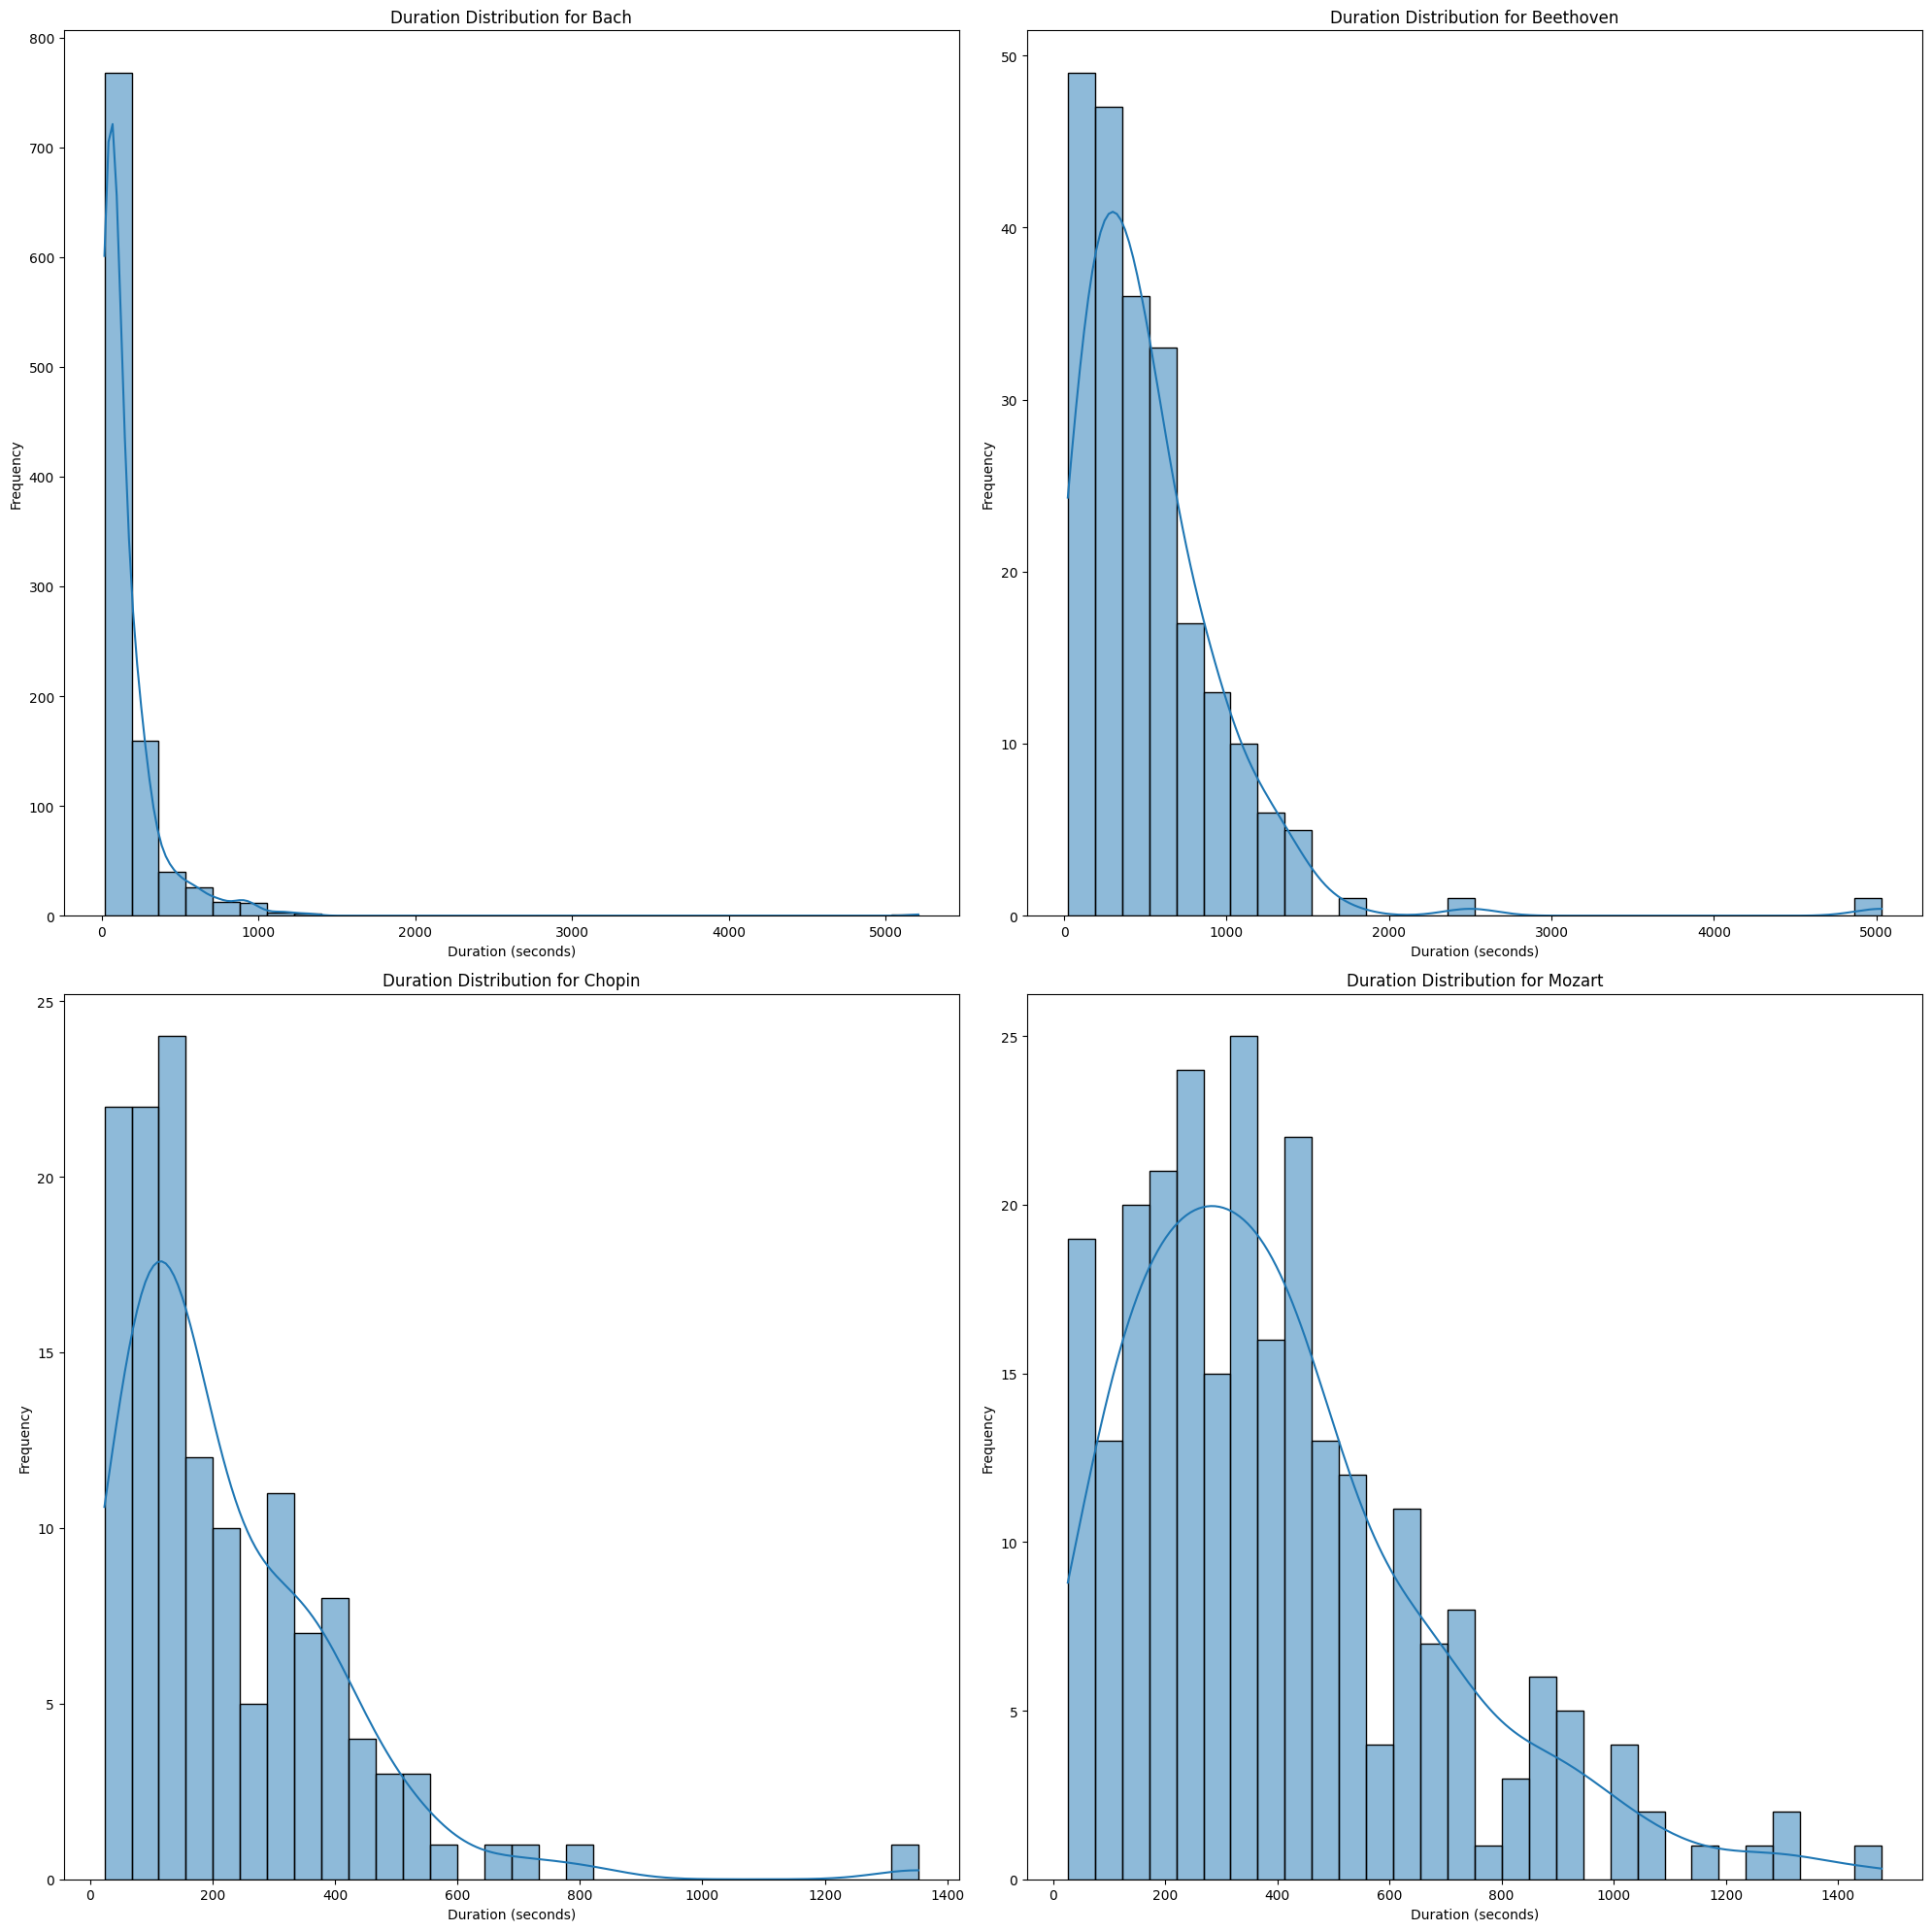

In [13]:
# Plot the distribution of the duration of each midi file
composer_df['duration_sec'].plot(kind='hist', bins=30, edgecolor='black')
plt.title('Distribution of Duration of MIDI Files')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

#Plot the distribution of the duration of each midi file for each composer separately in 2x2 grid
plt.figure(figsize=(20, 20))
for i, composer in enumerate(composer_df['composer_name'].unique(), 1):
    composer_data = composer_df[composer_df['composer_name'] == composer]
    plt.subplot(2, 2, i)
    sns.histplot(composer_data['duration_sec'], bins=30, kde=True)
    plt.title(f'Duration Distribution for {composer}')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


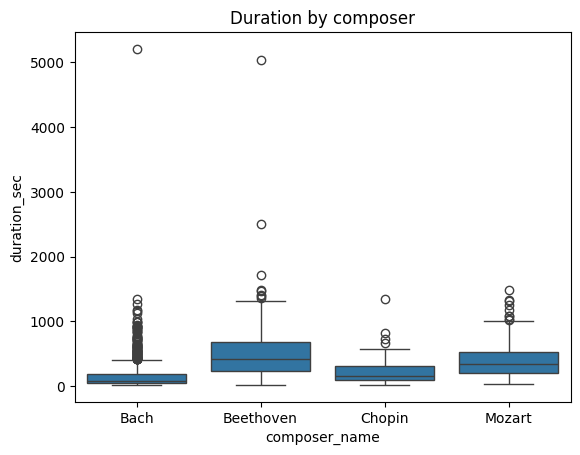

In [14]:
sns.boxplot(x='composer_name', y='duration_sec', data=composer_df)
plt.title("Duration by composer")
plt.show()

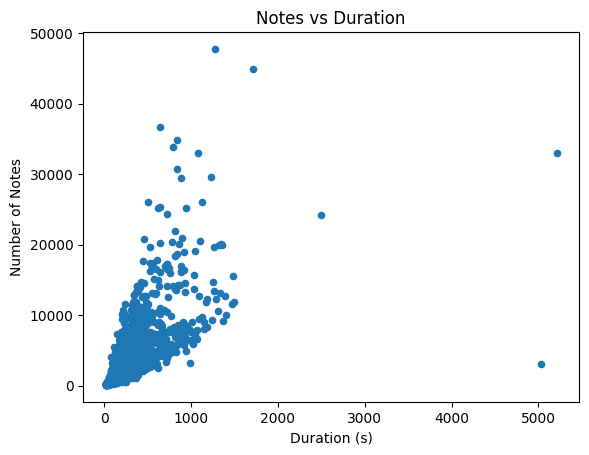

              num_notes  duration_sec
num_notes      1.000000      0.701524
duration_sec   0.701524      1.000000


In [15]:
composer_df.plot.scatter(x='duration_sec', y='num_notes')
plt.title("Notes vs Duration")
plt.xlabel("Duration (s)")
plt.ylabel("Number of Notes")
plt.show()

print(composer_df[['num_notes', 'duration_sec']].corr())

### Data is right skewed! 

Most files have a small num_notes and duration_sec, but a few outlier files have a very large number of notes and duration, which skews the distribution. Composers data looks a little different individually. 

Options: 
1. T_max at 95th percentile then truncate and pad the data done per composer based on number of notes
2. T_max at 95th percentile done globally then truncate and pad the data 



In [16]:
# Calculate T-max at 95th percentile for num_notes per composer
t_max_per_composer = composer_df.groupby('composer_name')['num_notes'].quantile(0.95).reset_index()
t_max_per_composer.columns = ['composer_name', 't_max']
print("T-max per composer calculated successfully.")
print(t_max_per_composer)
# Save the t_max_per_composer DataFrame to a CSV file 
t_max_per_composer.to_csv(csv_file_path / "t_max_per_composer.csv", index=False)
print("T-max per composer saved to CSV file successfully.")


#Calculate glabal T-max at 95th percentile for num_notes
global_t_max = int(composer_df['num_notes'].quantile(0.95))
print("\nGlobal T-max at 95th percentile for num_notes:", global_t_max)
# Save the global T-max dataframe to a CSV file
global_t_max_df = pd.DataFrame({'global_t_max': [global_t_max]})
global_t_max_df.to_csv(csv_file_path / "global_t_max.csv", index=False)
print("Global T-max saved to CSV file successfully.")



T-max per composer calculated successfully.
  composer_name     t_max
0          Bach   7395.10
1     Beethoven  25380.50
2        Chopin   5994.25
3        Mozart  13188.50
T-max per composer saved to CSV file successfully.

Global T-max at 95th percentile for num_notes: 12752
Global T-max saved to CSV file successfully.


## Data Preprocessing

In [17]:
# Convert composer names to numerical labels
composer_df['composer_label'] = composer_df['composer_name'].astype('category').cat.codes
# Save the updated DataFrame with composer labels to a new CSV file
composer_df.to_csv(csv_file_path / "composer_files_with_labels.csv", index=False)
print("CSV file with composer labels created successfully.")
print(dict(enumerate(composer_df['composer_name'].astype('category').cat.categories)))

composer_df.shape
composer_df.head()



CSV file with composer labels created successfully.
{0: 'Bach', 1: 'Beethoven', 2: 'Chopin', 3: 'Mozart'}


,composer_name,file_name,num_notes,duration_sec,composer_label
0,Bach,Bach_003706b_.mid,304.0,46.96,0
1,Bach,Bach_003806b_.mid,253.0,45.00,0
2,Bach,Bach_003907bv.mid,285.0,42.50,0
3,Bach,Bach_003907b_.mid,285.0,42.50,0
4,Bach,Bach_004003b_.mid,204.0,30.00,0


## Feature Engineering

For classical music, the most important identifying features are pitch, rhythm, and dynamics.
These features can be extracted from MIDI files and used to train a model to classify composers.
The features can be extracted using the pretty_midi library, which provides methods to extract pitch, rhythm, and dynamics from MIDI files.
Rhythm can be represented by the timing of notes (duration), while dynamics can be represented by the velocity of notes.

In [18]:
# Function to get the sequence of notes from a MIDI file
def get_sequence(file_path, global_t_max):
    try:
        midi_data = pretty_midi.PrettyMIDI(str(file_path))
    except Exception as e:
        print(f"Error loading MIDI file {file_path}: {e}")
        return None

    file_note_sequence = []
    for instrument in midi_data.instruments:
        if instrument.is_drum:
            continue
        for note in instrument.notes:
            file_note_sequence.append([
                note.pitch,
                note.velocity,
                note.end - note.start
            ])
            
    file_note_sequence = np.array(file_note_sequence)

    if len(file_note_sequence) == 0:
        seq = np.zeros((global_t_max, 3), dtype=np.float32)
    elif len(file_note_sequence) >= global_t_max:
        seq = file_note_sequence[:global_t_max, :]
    else:
        pad_len = global_t_max - len(file_note_sequence)
        pad = np.zeros((pad_len, 3), dtype=np.float32)
        seq = np.vstack((file_note_sequence, pad))

    return seq

## LSTM Preparation

In [19]:
# Define target and features
features = []
target = []

for index, row in composer_df.iterrows():
    file_path = destination_root / row['file_name']
    label = row['composer_label']

    seq = get_sequence(file_path, global_t_max)
    
    if seq is not None:
        features.append(seq)
        target.append(label)

features = np.stack(features)
target = np.array(target)

print("Features shape:", features.shape)
print("Target shape:", target.shape)

C:\Users\anitr\AppData\Roaming\Python\Python310\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Features shape: (1635, 12752, 3)
Target shape: (1635,)


In [20]:
# Save the features and target to numpy .npz file
np.savez_compressed(csv_file_path / "ltsm_composer_features_target.npz", features=features, target=target)
print("Features and target saved to .npz file successfully.")

Features and target saved to .npz file successfully.


In [ ]:
# Compute class weights for each composer based on the target labels
class_weights = compute_class_weight(    
    class_weight='balanced',
    classes=np.unique(composer_df['composer_label']),
    y=composer_df['composer_label']
)
print("Class weights computed successfully.")
# print class_weights for each composer
composer_class_weights = dict(zip(composer_df['composer_label'].unique(), class_weights))            
for composer_label, weight in composer_class_weights.items():
    print(composer_label, weight)

Class weights computed successfully.
0 0.399169921875
1 1.8664383561643836
2 3.005514705882353
3 1.5966796875
